In [16]:
import pandas as pd
import numpy as np
import os
import shutil
import glob

from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.resnet import preprocess_input, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten , Dense
from tensorflow.python.keras.models import load_model
import matplotlib.pyplot as plt 

In [17]:
NEW_DIR = "./database/"
ROOT_DIR = "./images/"

TRAIN_PATH  = "./database/train_test_split/train"
VALID_PATH  = "./database/train_test_split/validation"
TEST_PATH   = "./database/train_test_split/test"

objArrayDiseases = ["COVID", "Normal", "Pneumonia"]

In [18]:
objArrayCovid = pd.read_excel("./metadatas/covid.metadata.xlsx")
objArrayNormal = pd.read_excel("./metadatas/normal.metadata.xlsx")
objArrayPneumonia = pd.read_excel("./metadatas/pneumonia.metadata.xlsx")

In [19]:
for imgfile in glob.iglob(os.path.join(os.path.join(ROOT_DIR, "Pneumonia/"), "*.png")):
    os.rename(imgfile, imgfile.replace('Viral ', ''))

In [20]:
if not os.path.exists(NEW_DIR):
  os.mkdir(NEW_DIR)

  for i in objArrayDiseases:
    org_dir = os.path.join(ROOT_DIR, i+"/")
    
    for imgfile in glob.iglob(os.path.join(org_dir, "*.png")):
      shutil.copy(imgfile, NEW_DIR)
      
else:
  print("Already Exist")

Already Exist


In [21]:
if not os.path.exists(NEW_DIR+"train_test_split/"):

  os.makedirs(NEW_DIR+"train_test_split/")

  os.makedirs(NEW_DIR+"train_test_split/train/Normal")
  os.makedirs(NEW_DIR+"train_test_split/train/COVID")
  os.makedirs(NEW_DIR+"train_test_split/train/Pneumonia")

  os.makedirs(NEW_DIR+"train_test_split/test/Normal")
  os.makedirs(NEW_DIR+"train_test_split/test/COVID")
  os.makedirs(NEW_DIR+"train_test_split/test/Pneumonia")

  os.makedirs(NEW_DIR+"train_test_split/validation/Normal")
  os.makedirs(NEW_DIR+"train_test_split/validation/COVID")
  os.makedirs(NEW_DIR+"train_test_split/validation/Pneumonia")


  # Train Data
  for i in np.random.choice(replace= False , size= 3000 , a = glob.glob(NEW_DIR+objArrayDiseases[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/COVID" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 3900 , a = glob.glob(NEW_DIR+objArrayDiseases[1]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 900 , a = glob.glob(NEW_DIR+objArrayDiseases[2]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/Pneumonia" )
    os.remove(i)


  # Validation Data
  for i in np.random.choice(replace= False , size= 308 , a = glob.glob(NEW_DIR+objArrayDiseases[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/COVID" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 500 , a = glob.glob(NEW_DIR+objArrayDiseases[1]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 200 , a = glob.glob(NEW_DIR+objArrayDiseases[2]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/Pneumonia" )
    os.remove(i)

  # Test Data
  for i in np.random.choice(replace= False , size= 300 , a = glob.glob(NEW_DIR+objArrayDiseases[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/COVID" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 300 , a = glob.glob(NEW_DIR+objArrayDiseases[1]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 200 , a = glob.glob(NEW_DIR+objArrayDiseases[2]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/Pneumonia" )
    os.remove(i)    

In [22]:
objTrainGenerator = ImageDataGenerator(preprocessing_function= preprocess_input, 
                                    zoom_range= 0.2, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2,
                                    
                                    )

objTrain = objTrainGenerator.flow_from_directory(directory= TRAIN_PATH, 
                                           target_size=(224,224))

Found 7800 images belonging to 3 classes.


In [23]:
objValidGenerator = ImageDataGenerator(preprocessing_function= preprocess_input  )

objValid = objValidGenerator.flow_from_directory(directory= VALID_PATH, 
                                                target_size=(224,224))

Found 1008 images belonging to 3 classes.


In [24]:
objTestGenerator = ImageDataGenerator(preprocessing_function= preprocess_input )

objTest = objTestGenerator.flow_from_directory(directory= TEST_PATH , 
                                          target_size=(224,224), 
                                          shuffle= False)

Found 800 images belonging to 3 classes.


In [25]:
classifier = ResNet50( input_shape=(224,224,3), include_top= False)

for layer in classifier.layers:       
  layer.trainable = False

In [29]:
print (classifier.output)

objLayers = Flatten()(classifier.output)
objLayers = Dense(units=3 , activation='sigmoid', name = 'predictions' )(objLayers)

objModel = Model(classifier.input, objLayers)
objModel.compile( optimizer= 'adam' , loss = 'categorical_crossentropy', metrics=['accuracy'])
objModel.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 2048), dtype=tf.float32, name=None), name='conv5_block3_out/Relu:0', description="created by layer 'conv5_block3_out'")
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNorm

In [30]:
earlyStopping = EarlyStopping(monitor= "val_accuracy" , min_delta= 0.01, patience= 3, verbose=1)
modelCheckpoint = ModelCheckpoint(filepath="bestmodel.h5", monitor="val_accuracy", verbose=1, save_best_only= True)

In [31]:
objFit = objModel.fit_generator(objTrain, steps_per_epoch= 10, epochs= 30, validation_data=objValid , validation_steps= 16, callbacks=[earlyStopping, modelCheckpoint])

Epoch 1/30
10/10 [==============================] - 104s 11s/step - loss: 3.9736 - accuracy: 0.7031 - val_loss: 2.1768 - val_accuracy: 0.8379

Epoch 00001: val_accuracy improved from -inf to 0.83789, saving model to bestmodel.h5


C:\Users\gabri\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
10/10 [==============================] - 100s 10s/step - loss: 3.1036 - accuracy: 0.7917 - val_loss: 3.1728 - val_accuracy: 0.8379

Epoch 00002: val_accuracy did not improve from 0.83789
Epoch 3/30
10/10 [==============================] - 100s 10s/step - loss: 3.6375 - accuracy: 0.8062 - val_loss: 2.3408 - val_accuracy: 0.8379

Epoch 00003: val_accuracy did not improve from 0.83789
Epoch 4/30
10/10 [==============================] - 93s 10s/step - loss: 3.6681 - accuracy: 0.7969 - val_loss: 1.9861 - val_accuracy: 0.8770

Epoch 00004: val_accuracy improved from 0.83789 to 0.87695, saving model to bestmodel.h5
Epoch 5/30
10/10 [==============================] - 98s 10s/step - loss: 2.2152 - accuracy: 0.8562 - val_loss: 1.6649 - val_accuracy: 0.8848

Epoch 00005: val_accuracy improved from 0.87695 to 0.88477, saving model to bestmodel.h5
Epoch 6/30
10/10 [==============================] - 103s 11s/step - loss: 1.6840 - accuracy: 0.8656 - val_loss: 1.5465 - val_accuracy: 0.9141


In [32]:
objModel = load_model("bestmodel.h5")

nr_Acurracy = objModel.evaluate_generator(generator=objTest)[1] 

print(f"A acurácia do modelo selecionado foi de = {nr_Acurracy}%")

C:\Users\gabri\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:2002: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


A acurácia do modelo selecionado foi de = 0.9049999713897705%


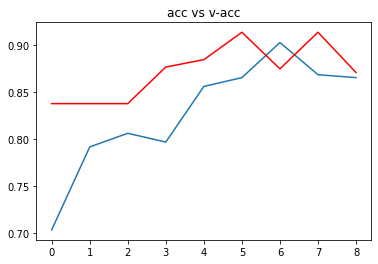

In [33]:
objHistory = objFit.history

plt.plot(objHistory['accuracy'])
plt.plot(objHistory['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

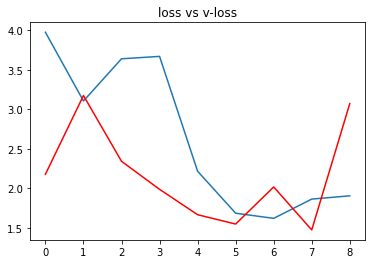

In [34]:
objHistory = objFit.history

plt.plot(objHistory['loss'])
plt.plot(objHistory['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

A imagem é da seguinte class: Pneumonia

As chances da imagem ser da classe COVID é: 3.4991635782487263e-12 porcento

As chances da imagem ser da classe Normal é: 0.00022279236873146147 porcento

As chances da imagem ser da classe Pneumonia é: 99.99996423721313 porcento


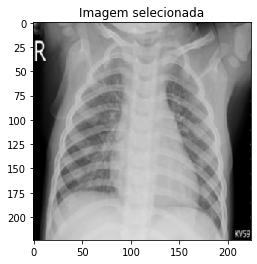

In [37]:
def Get_Image(ds_Image_Path):
  path = ds_Image_Path
  objImage = image.load_img(path, target_size=(224,224,3))
  objImage = image.img_to_array(objImage)
  objImage = np.expand_dims(objImage , axis= 0 )
  
  return objImage


ds_Image_Path = "./database/Pneumonia-452.png"   
objImage = Get_Image(ds_Image_Path)

objClassType = {0:'Covid',  1 : 'Normal', 2: 'Pneumonia'}

res = objClassType[np.argmax(objModel.predict(objImage))]

print(f"A imagem é da seguinte class: {res}")
print()
print(f"As chances da imagem ser da classe COVID é: {objModel.predict(objImage)[0][0]*100} porcento")
print()
print(f"As chances da imagem ser da classe Normal é: {objModel.predict(objImage)[0][1]*100} porcento")
print()
print(f"As chances da imagem ser da classe Pneumonia é: {objModel.predict(objImage)[0][2]*100} porcento")

plt.imshow(objImage[0]/255, cmap = "gray")
plt.title("Imagem selecionada")
plt.show()